# _Deep Q-Network Learning_
## with Lunar Lander by OpenAI Gym

In this project, it will train an agent to land a lunar lander safely on a landing pad on the surface of the moon.

---

by Naufal Mu'afi

_copyright to prof. Andrew NG and DeepLearning.AI_

## 1. Import Packages
First, import all necessary packages

In [1]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [2]:
# set up a virtual display to render the Lunar Lander environment
# Display(visible=0, size=(840, 480)).start()

# set the random seed for TensorFlow
tf.random.set_seed(utils.SEED)

## 2. Hyperparameters

In [3]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

## 3. The Lunar Lander Environment

## 4. Load The Lunar Lander Environment

In [4]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")

In [5]:
env.reset()
# PIL.Image.fromarray(env.render(mode='rgb_array'))

(array([-6.2274933e-04,  1.4108660e+00, -6.3091502e-02, -2.4126652e-03,
         7.2836626e-04,  1.4291185e-02,  0.0000000e+00,  0.0000000e+00],
       dtype=float32),
 {})

In [6]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print(f"State Shape = {state_size}")
print(f"Number of Actions = {num_actions}")

State Shape = (8,)
Number of Actions = 4


## 5. Interacting with the Gym Environment

In [7]:
initial_state = env.reset()

In [8]:
# select the action
action = 0

# run a single time step of the environment's dynamics with the given action
next_state, reward, done, _, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
  print(f"Initial State\t\t: {initial_state}")
  print(f"Action\t\t\t: {action}")
  print(f"Next State\t\t: {next_state}")
  print(f"Reward Received\t\t: {reward}")
  print(f"Episode Terminated\t: {done}")
  print(f"Info\t\t\t: {info}")

Initial State		: (array([-0.007, 1.422, -0.662, 0.504, 0.008, 0.150, 0.000, 0.000],
      dtype=float32), {})
Action			: 0
Next State		: [-0.013 1.433 -0.661 0.479 0.015 0.148 0.000 0.000]
Reward Received		: -0.21677471450837515
Episode Terminated	: False
Info			: {}


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## 6. Deep Q-Learning

### 6.1 Target Network

In [9]:
# Create the Q-Network
q_network = Sequential([
  Input(shape=state_size),
  Dense(units=64, activation='relu'),
  Dense(units=64, activation='relu'),
  Dense(units=num_actions, activation='linear')
])

# Create the Target Q-Network
target_q_network = Sequential([    
  Input(shape=state_size),                      
  Dense(units=64, activation='relu'),            
  Dense(units=64, activation='relu'),            
  Dense(units=num_actions, activation='linear'),    
])

optimizer = Adam(learning_rate=ALPHA)

In [10]:
# UNIT TEST
from public_tests import *

test_network(q_network)
test_network(target_q_network)
test_optimizer(optimizer, ALPHA)

All tests passed!
All tests passed!
All tests passed!


### 6.2 Experience Replay

In [11]:
# store expericences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

## 7. Deep Q-Learning Algorithm with Experience Replay

In [12]:
def compute_loss(experiences, gamma, q_network, target_q_network):
  """ 
    Calculates the loss.
    
    Args:
      experiences       : (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma             : (float) The discount factor.
      q_network         : (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network  : (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between the y targets and the Q(s,a) values.
  """
  
  # unpack the mini-batch of experience tuples
  states, actions, rewards, next_states, done_vals = experiences
  
  # compute max Q^(s,a)
  max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
  
  # set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
  y_targets = reward + (gamma * max_qsa * (1 - done_vals))
  
  # get the q_values
  q_values = q_network(states)
  q_values = tf.gather_nd(
    q_values,
    tf.stack([tf.range(q_values.shape[0]),
              tf.cast(actions, tf.int32)],
             axis=1)
  )
  
  # compute the loss
  loss = MSE(y_targets, q_values)
  
  return loss

## 8. Update the Network Weights

In [13]:
@tf.function
def agent_learn(experiences, gamma):
  """
    Updates the weights of the Q networks.
    
    Args:
      experiences : (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma       : (float) The discount factor.
  """
  
  # calculate the loss
  with tf.GradientTape() as tape:
    loss = compute_loss(experiences, gamma, q_network, target_q_network)
  
  # get the gradients of the loss with respect to the weights
  gradients = tape.gradient(loss, q_network.trainable_variables)
  
  # update the weights of the q_network
  optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
  
  # update the weights of target q_network
  utils.update_target_network(q_network, target_q_network)

In [34]:
state = env.reset()
print(state[0].shape)
state_qn = np.expand_dims(state[0], axis=0)
print(state_qn.shape)

(8,)
(1, 8)


## 9. Train the Agent

In [42]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100  # number of total points to use for averaging
epsilon = 1.0   # initialize ε value for ε-greedy policy

# create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
  
  # reset the env to the initial state/obs space and get the initial state
  state = env.reset()
  state = state[0]
  total_points = 0
  
  for t in range(max_num_timesteps):    
    # from the current states S choose an action A using an ε-greedy policy  
    state_qn = np.expand_dims(state, axis=0) # Expand dimensions of the numpy array                    

    q_values = q_network(state_qn)    
    action = utils.get_action(q_values, epsilon)
    
    # take action A and receive reward R and the next state S'
    next_state, reward, done, _, _ = env.step(action)
    
    # Store experience tuple (S,A,R,S') in the memory buffer.
    # We store the done variable as well for convenience.
    memory_buffer.append(experience(state, action, reward, next_state, done))
        
    # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
    update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
    if update:
      # Sample random mini-batch of experience tuples (S,A,R,S') from D
      experiences = utils.get_experiences(memory_buffer)
            
      # Set the y targets, perform a gradient descent step,
      # and update the network weights.
      agent_learn(experiences, GAMMA)
        
    state = next_state.copy()
    total_points += reward
        
    if done:
      break
  
  total_point_history.append(total_points)
  av_latest_points = np.mean(total_point_history[-num_p_av:])
  
  # Update the ε value
  epsilon = utils.get_new_eps(epsilon)
  
  print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")
  
  if (i+1) % num_p_av == 0:
    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
  
  # We will consider that the environment is solved if we get an
  # average of 200 points in the last 100 episodes.
  
  if av_latest_points >= 200.0:
    print(f"\n\nEnvironment solved in {i+1} episodes!")
    q_network.save('lunar_lander_model.h5')
    
    break

tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -232.26
Episode 200 | Total point average of the last 100 episodes: -263.09
Episode 300 | Total point average of the last 100 episodes: -282.34
Episode 400 | Total point average of the last 100 episodes: -335.17
Episode 500 | Total point average of the last 100 episodes: -349.77
Episode 600 | Total point average of the last 100 episodes: -343.43
Episode 700 | Total point average of the last 100 episodes: -329.29
Episode 800 | Total point average of the last 100 episodes: -360.46
Episode 900 | Total point average of the last 100 episodes: -336.80
Episode 1000 | Total point average of the last 100 episodes: -386.21
Episode 1100 | Total point average of the last 100 episodes: -352.58
Episode 1200 | Total point average of the last 100 episodes: -282.49
Episode 1300 | Total point average of the last 100 episodes: -337.87
Episode 1400 | Total point average of the last 100 episodes: -433.61
Episode 1500 | Total point average of the l

InvalidIndexError: (slice(None, None, None), None)

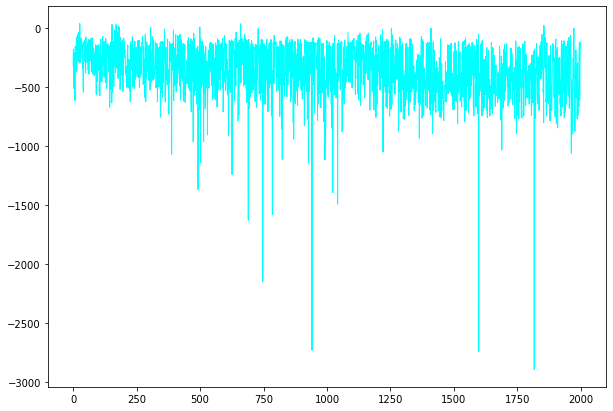

In [43]:
# Plot the point history
utils.plot_history(total_point_history)